<a href="https://colab.research.google.com/github/y0umu/pytorch-cifar10-playground/blob/master/cifar10_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [0]:
# !pip install -U -q tensorboardX
# tensorboardX might not be neccessary in the future as pytorch started
# to add experimental torch.utils.tensorboard support in 1.1.0. 
# The syntax is very similiar to that of tensorboardX
# see https://pytorch.org/docs/stable/tensorboard.html for more details

In [20]:
# hopefully we can try TF 2.0 to use tensorboard directly in notebook
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Pydrive

In [0]:
!pip install -U -q PyDrive

In [0]:
# if the upload has to fail I will do that manually
from pathlib import Path
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# !mkdir authentication

gauth = GoogleAuth()
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    # Authenticate if they're not there
    # self.gauth.LocalWebserverAuth()
    print("no creds saved")
    auth.authenticate_user()
    gauth.credentials = GoogleCredentials.get_application_default()
elif gauth.access_token_expired:
    # Refresh them if expired
    print("token expired")
    gauth.Refresh()
else:
    # Initialize the saved creds
    print("Initialize the saved creds")
    gauth.Authorize()
# Save the current credentials to a file
gauth.SaveCredentialsFile("mycreds.txt") 


############################################
# the_drive = GoogleDrive(gauth)
# ckpt_name = "ResCsNet-colab-5_2_1-r0.10_checkpoint.pth"


# id_file = Path('_id')
# if id_file.exists():
#     print("_id exsits")
#     fileid = id_file.read_text()
#     _gfile_ckpt = the_drive.CreateFile({'id': fileid})
#     _gfile_ckpt.SetContentFile(ckpt_name)
#     _gfile_ckpt.Upload()
# else:
#     print("_id not exsits")
#     _gfile_ckpt = the_drive.CreateFile()      
#     _gfile_ckpt.SetContentFile(ckpt_name)
#     _gfile_ckpt.Upload()
#     id_file.write_text(_gfile_ckpt['id']) 
print("Done")

## Old style hacks
These hacks are intended for backup and view tensorboard thru a third-party remote host. Hopefully they will not have to be used in the future.

### http.server

In [0]:
get_ipython().system_raw("python3 -m http.server 8000 --bind 127.0.0.1 &")
!ps -ef | grep http

### frpc

In [0]:
!wget "https://github.com/fatedier/frp/releases/download/v0.24.1/frp_0.24.1_linux_amd64.tar.gz"
!mkdir frp
!tar -xvf "frp_0.24.1_linux_amd64.tar.gz" -C frp

In [0]:
get_ipython().system_raw("./frp/frp_0.24.1_linux_amd64/frpc -c ./frpc.ini &")
#!./frp/frp_0.24.1_linux_amd64/frpc -c ./frpc.ini

#=======================

# Real things

In [21]:
import torch
print(f'using pytorch {torch.version.__version__}')

using pytorch 1.1.0


## Dataset

In [22]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

BATCH_SIZE = 64

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # mean, std
  ]  
)

dset_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dset_test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

loader_train = DataLoader(dset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
loader_test = DataLoader(dset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


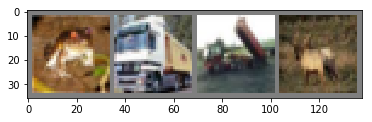

['frog', 'truck', 'truck', 'deer']


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pdb

# visulize some of them
trainld_iter = iter(loader_train)
images, labels = trainld_iter.next()

imgrid = torchvision.utils.make_grid(images[:4])
imgrid = imgrid / 2.0 + 0.5
imgrid_np = imgrid.numpy()
# pdb.set_trace()

plt.imshow(imgrid_np.transpose([1,2,0]))
plt.show()

print([classes[x.item()] for x in labels[:4] ])

## The network

In [24]:
import torch.nn as nn
import pdb

class MyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn3   = nn.BatchNorm2d(256)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2)  # (N, C, 4, 4)
    
    self.fc1 = nn.Linear(4*4*256, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 10)
    
    self._init_weights()
    
  def forward(self, x):
    '''
    x: the image batch of (N, C, H, W)
    '''
    x = self.bn1(self.conv1(x))
    x = self.pool1(self.relu1(x))

    x = self.bn2(self.conv2(x))
    x = self.pool2(self.relu2(x))
    
    x = self.bn3(self.conv3(x))
    x = self.pool3(self.relu3(x))
    
    s = x.view((x.shape[0], -1))

    s = self.fc1(s)
    s = self.fc2(s)
    s = self.fc3(s)
    
    return s
    
  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')

def test_net():
  model = MyNet()
  x = torch.randn(BATCH_SIZE, 3, 32, 32)
  with torch.no_grad():
    model.eval()
    s = model(x)
  print(s.size())
  
test_net()

torch.Size([64, 10])


## Training function(s)

In [0]:
!mkdir runs

In [0]:
def save_checkpoint(model, optimizer, tfx_status_dict, ckpt_name='ckpt.pth'):
  state = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'tfx_status_dict': tfx_status_dict
  }
  torch.save(state, ckpt_name)

In [0]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pdb

def train(model, loader_train, optimizer, tfx_status_dict,
          epochs=1, loss_fn=nn.CrossEntropyLoss(), dev=torch.device('cuda')):
  writer = SummaryWriter(log_dir='./runs/original')  # note the difference between logdir and log_dir
  for e in range(epochs):
    print(f'epoch {tfx_status_dict["epochs"]}')
    for t, (images, labels) in enumerate(loader_train):
      model.train()
      images = images.to(device=dev)
      labels = labels.to(device=dev)
      optimizer.zero_grad()
      scores = model(images)

      loss = loss_fn(scores, labels)

      loss.backward()
      optimizer.step()
      
      if t % 50 == 0:
        print(f'iteration {t}/{len(loader_train)}, loss={loss.item()}')
      tfx_status_dict['steps'] += 1
      
      writer.add_scalar('train/loss', loss.item(), tfx_status_dict['steps'])
    
    tfx_status_dict['epochs'] += 1
    
    writer.close()

In [0]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pdb

def train_with_l2_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l2=1.0,
          epochs=1, loss_fn=nn.CrossEntropyLoss(), dev=torch.device('cuda')):
  writer = SummaryWriter(log_dir='./runs/with_l2_reg_2')  # note the difference between logdir and log_dir
  for e in range(epochs):
    print(f'epoch {tfx_status_dict["epochs"]}')
    for t, (images, labels) in enumerate(loader_train):
      model.train()
      images = images.to(device=dev)
      labels = labels.to(device=dev)
      optimizer.zero_grad()
      scores = model(images)

      loss_cross_entropy = loss_fn(scores, labels)
      loss_l2 = 0.0
      for p in model.parameters():
        loss_l2 += p.norm()
      
      loss = loss_cross_entropy + lambda_l2 * loss_l2

      loss.backward()
      optimizer.step()
      
      if t % 50 == 0:
        print(f'iteration {t}/{len(loader_train)}, loss={loss.item()}')
      tfx_status_dict['steps'] += 1
      
      writer.add_scalars('train/loss', {
          'loss_cross_entropy': loss_cross_entropy.item(),
          'loss_l2'           : loss_l2.item(),
          'loss'              : loss.item()
      },
               tfx_status_dict['steps'])
    
    tfx_status_dict['epochs'] += 1
    
    writer.close()

In [0]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pdb

def train_with_l1_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l1=1.0,
          epochs=1, loss_fn=nn.CrossEntropyLoss(), dev=torch.device('cuda')):
  writer = SummaryWriter(log_dir='./runs/with_l1_reg_2')  # note the difference between logdir and log_dir
  for e in range(epochs):
    print(f'epoch {tfx_status_dict["epochs"]}')
    for t, (images, labels) in enumerate(loader_train):
      model.train()
      images = images.to(device=dev)
      labels = labels.to(device=dev)
      optimizer.zero_grad()
      scores = model(images)

      loss_cross_entropy = loss_fn(scores, labels)
      loss_l1 = 0.0
      for p in model.parameters():
        loss_l1 += p.norm(p=1)
      
      loss = loss_cross_entropy + lambda_l1 * loss_l1

      loss.backward()
      optimizer.step()
      
      if t % 50 == 0:
        print(f'iteration {t}/{len(loader_train)}, loss={loss.item()}')
      tfx_status_dict['steps'] += 1
      
      writer.add_scalars('train/loss', {
          'loss_cross_entropy': loss_cross_entropy.item(),
          'loss_l1'           : loss_l1.item(),
          'loss'              : loss.item()
      },
               tfx_status_dict['steps'])
    
    tfx_status_dict['epochs'] += 1
    
    writer.close()

In [60]:
try:
  del model
  print("deleted existing model")
except NameError:
  pass

model = MyNet()  
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
tfx_status_dict = {'steps':0, 'epochs':0}

deleted existing model


## Inline tensorboard and training
Need tensorflow >= 2.0

In [0]:
%tensorboard --logdir runs

In [62]:
# train(model, loader_train, optimizer, tfx_status_dict, epochs=50)

# train_with_l2_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l2=0.005, epochs=10)
# train_with_l2_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l2=0.0005, epochs=10)
# train_with_l2_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l2=0.001, epochs=10)
# train_with_l2_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l2=0.001, epochs=20)

# train_with_l1_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l1=0.01, epochs=10)
train_with_l1_reg(model, loader_train, optimizer, tfx_status_dict, lambda_l1=0.01, epochs=40)

print("Done")

epoch 10
iteration 0/782, loss=2.8627471923828125
iteration 50/782, loss=2.827289581298828
iteration 100/782, loss=2.7558608055114746
iteration 150/782, loss=2.8056254386901855
iteration 200/782, loss=2.5629358291625977
iteration 250/782, loss=2.705570697784424
iteration 300/782, loss=2.7944743633270264
iteration 350/782, loss=2.7039051055908203
iteration 400/782, loss=2.763612747192383
iteration 450/782, loss=2.4838833808898926
iteration 500/782, loss=2.7851905822753906
iteration 550/782, loss=2.6206140518188477
iteration 600/782, loss=2.724606990814209
iteration 650/782, loss=2.7772023677825928
iteration 700/782, loss=2.814997911453247
iteration 750/782, loss=3.147218704223633
epoch 11
iteration 0/782, loss=2.871213436126709
iteration 50/782, loss=2.8326973915100098
iteration 100/782, loss=2.7381343841552734
iteration 150/782, loss=2.779848098754883
iteration 200/782, loss=2.615354537963867
iteration 250/782, loss=2.7115209102630615
iteration 300/782, loss=2.789180278778076
iteration

In [63]:
print(tfx_status_dict)

{'steps': 39100, 'epochs': 50}


In [0]:
save_checkpoint(model, optimizer, tfx_status_dict, 'with_l1_reg.pth')

In [65]:
!tar -cjvf runs.tar.bz2 runs

runs/
runs/Jun25_06-10-04_58b9bfe23b37/
runs/Jun25_06-10-04_58b9bfe23b37/events.out.tfevents.1561443004.58b9bfe23b37.3594.0
runs/Jun25_06-10-23_58b9bfe23b37/
runs/Jun25_06-10-23_58b9bfe23b37/events.out.tfevents.1561443023.58b9bfe23b37.3594.2
runs/with_l2_reg_2/
runs/with_l2_reg_2/events.out.tfevents.1561445267.58b9bfe23b37.117.335
runs/with_l2_reg_2/events.out.tfevents.1561445127.58b9bfe23b37.117.299
runs/with_l2_reg_2/events.out.tfevents.1561445318.58b9bfe23b37.117.351
runs/with_l2_reg_2/events.out.tfevents.1561445102.58b9bfe23b37.117.291
runs/with_l2_reg_2/events.out.tfevents.1561444466.58b9bfe23b37.117.207
runs/with_l2_reg_2/events.out.tfevents.1561445191.58b9bfe23b37.117.319
runs/with_l2_reg_2/events.out.tfevents.1561445022.58b9bfe23b37.117.283
runs/with_l2_reg_2/events.out.tfevents.1561445280.58b9bfe23b37.117.339
runs/with_l2_reg_2/events.out.tfevents.1561445394.58b9bfe23b37.117.375
runs/with_l2_reg_2/events.out.tfevents.1561445166.58b9bfe23b37.117.311
runs/with_l2_reg_2/events.ou

In [15]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [66]:
!cp -v original.pth with_l1_reg.pth with_l2_reg.pth runs.tar.bz2 "drive/My Drive/cifar10-playground"

'original.pth' -> 'drive/My Drive/cifar10-playground/original.pth'
'with_l1_reg.pth' -> 'drive/My Drive/cifar10-playground/with_l1_reg.pth'
'with_l2_reg.pth' -> 'drive/My Drive/cifar10-playground/with_l2_reg.pth'
'runs.tar.bz2' -> 'drive/My Drive/cifar10-playground/runs.tar.bz2'


## Testing

In [67]:
import pdb

def naive_acc(model):
  classes_total = [0.0 for i in range(10)]
  classes_correct = [0.0 for i in range(10)]
  model.eval()
  model = model.cuda()
  with torch.no_grad():
    for t, (images, labels) in enumerate(loader_test):
      images = images.cuda()
      labels = labels.cuda()
      scores = model(images)
      _, predicts = torch.max(scores, 1)
      c = (predicts == labels)
      for i, label in enumerate(labels):
        classes_correct[label] += c[i].item()
        classes_total[label] += 1
  for i in range(10):
    print(f'accuracy for class {i} is {classes_correct[i]/classes_total[i]}')
  
naive_acc(model)    

accuracy for class 0 is 0.474
accuracy for class 1 is 0.683
accuracy for class 2 is 0.275
accuracy for class 3 is 0.137
accuracy for class 4 is 0.264
accuracy for class 5 is 0.569
accuracy for class 6 is 0.749
accuracy for class 7 is 0.533
accuracy for class 8 is 0.711
accuracy for class 9 is 0.615


I am logging the experiments results.

Using epochs=50, lr=1e-3

class id | original | with l2 reg | with l1 reg |
-------- | -------- | ----------- | ----------- |
0        | 0.697    | 0.775       | 0.474
1        | 0.875    | 0.872       | 0.683
2        | 0.717    | 0.641       | 0.275
3        | 0.604    | 0.663       | 0.137
4        | 0.787    | 0.785       | 0.264
5        | 0.684    | 0.722       | 0.569
6        | 0.838    | 0.778       | 0.749
7        | 0.776    | 0.844       | 0.533
8        | 0.919    | 0.854       | 0.711
9        | 0.886    | 0.802       | 0.615
avg    | 0.778   | 0.777      | 0.501
std     |0.102   | 0.078 | 0.210

The experiment with L1 regularization seems to be poorly tuned.